In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

newTrain, newValid, newTest = convertOneHot(trainTarget, validTarget, testTarget)

In [ ]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

def ReLU(x):
  return np.maximum(x, 0)

def softmax(z):
  zTilde = z - np.transpose(np.tile(np.amax(z, axis=1), (z.shape[1],1)))
  return np.exp(zTilde)/np.sum(np.exp(zTilde), axis=1)[:,None]

def computeLayer(X, W, b):
  return np.matmul(X, W) + b

def averageCE(target, prediction):
  # The following line prevents division by zero errors in np.log
  prediction[prediction == 0] = 1e-15
  return -np.sum(np.multiply(target, np.log(prediction))) / target.shape[0]

def gradCE(target, prediction):
  return prediction - target

def gradLossOuterWeights(target, prediction, X1):
  X1Trans = np.transpose(X1)
  gradLossSoftmaxInput = gradCE(target, prediction)
  return np.matmul(X1Trans, gradLossSoftmaxInput)

def gradLossOuterBias(target, prediction):
  onesRow = np.ones((1, target.shape[0]))
  gradLossSoftmaxInput = gradCE(target, prediction)
  return np.matmul(onesRow, gradLossSoftmaxInput)

def gradLossHiddenWeights(X0, S1, W_o, target, prediction):
  S1[S1 > 0] = 1
  S1[S1 < 0] = 0
  X0Trans = np.transpose(X0)
  gradLossSoftmaxInput = gradCE(target, prediction)
  W_o_trans = np.transpose(W_o)
  return np.matmul(X0Trans, S1 * np.matmul(gradLossSoftmaxInput, W_o_trans))

def gradLossHiddenBias(S1, W_o, target, prediction):
  S1[S1 > 0] = 1
  S1[S1 < 0] = 0
  onesRow = np.ones((1, target.shape[0]))
  gradLossSoftmaxInput = gradCE(target, prediction)
  W_o_trans = np.transpose(W_o)
  return np.matmul(onesRow, S1 * np.matmul(gradLossSoftmaxInput, W_o_trans))


In [ ]:
def learning(W_o, W_h, b_o, b_h, v_W_o, v_W_h, v_b_o, v_b_h, epochs, gamma, \
    alpha, trainData, trainTarget, validData, validTarget, testData, testTarget):
  trainAccuracy = []
  validAccuracy = []
  testAccuracy = []
  trainLoss = []
  validLoss = []
  testLoss = []

  for i in range(epochs):
    S1 = computeLayer(trainData, W_h, b_h)
    X1 = ReLU(S1)
    Z = computeLayer(X1, W_o, b_o)
    P = softmax(Z)
    trainLoss.append(averageCE(trainTarget, P))
    predictions = np.argmax(P, axis = 1)
    labels = np.argmax(trainTarget, axis = 1)
    numberCorrect = np.sum(np.equal(predictions, labels) == True)
    trainAccuracy.append(numberCorrect / trainData.shape[0])

    S1Valid = computeLayer(validData, W_h, b_h)
    X1Valid = ReLU(S1Valid)
    ZValid = computeLayer(X1Valid, W_o, b_o)
    PValid = softmax(ZValid)
    validLoss.append(averageCE(validTarget, PValid))
    predictionsValid = np.argmax(PValid, axis = 1)
    labelsValid = np.argmax(validTarget, axis = 1)
    numberCorrectValid = np.sum(np.equal(predictionsValid, labelsValid) == True)
    validAccuracy.append(numberCorrectValid / validData.shape[0])

    S1Test = computeLayer(testData, W_h, b_h)
    X1Test = ReLU(S1Test)
    ZTest = computeLayer(X1Test, W_o, b_o)
    PTest = softmax(ZTest)
    testLoss.append(averageCE(testTarget, PTest))
    predictionsTest = np.argmax(PTest, axis = 1)
    labelsTest = np.argmax(testTarget, axis = 1)
    numberCorrectTest = np.sum(np.equal(predictionsTest, labelsTest) == True)
    testAccuracy.append(numberCorrectTest / testData.shape[0])

    print("Epoch:", i)
    v_W_o = gamma * v_W_o + alpha * gradLossOuterWeights(trainTarget, P, X1)
    W_o = W_o - v_W_o
    v_b_o = gamma * v_b_o + alpha * gradLossOuterBias(trainTarget, P)
    b_o = b_o - v_b_o

    v_W_h = gamma * v_W_h + alpha * gradLossHiddenWeights(trainData, S1, W_o, trainTarget, P)
    W_h = W_h - v_W_h
    v_b_h = gamma * v_b_h + alpha * gradLossHiddenBias(S1, W_o, trainTarget, P)
    b_h = b_h - v_b_h

  return W_o, W_h, b_o, b_h, trainAccuracy, validAccuracy, testAccuracy, trainLoss, validLoss, testLoss

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Final trai

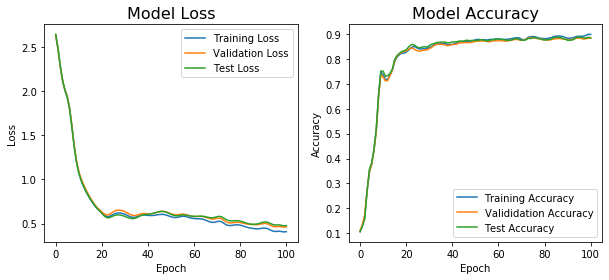

In [ ]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape((trainData.shape[0], trainData.shape[1] * trainData.shape[2]))
validData = validData.reshape((-1, validData.shape[1] * validData.shape[2])) 
testData = testData.reshape((-1, testData.shape[1] * testData.shape[2]))

############################### PARAMETERS ###############################

epochs = 200
# NOTE: Using 1e-6 instead of 1e-5 as in the assignment
alpha = 1e-6
gamma = 0.99
hiddenUnits = 1000
output_image_filename = 'Numpy_1000_Hidden_Units.png'

# For initializing weight matrices
mean = 0
variance_o = 2 / (hiddenUnits + 10)
variance_h = 2 / (trainData.shape[1] + hiddenUnits)

##########################################################################

trainOneHot, validOneHot, testOneHot = convertOneHot(trainTarget, validTarget, testTarget)

W_o = np.random.normal(mean, np.sqrt(variance_o), (hiddenUnits, 10))
W_h = np.random.normal(mean, np.sqrt(variance_h), (trainData.shape[1], hiddenUnits))

b_o = np.zeros((1, 10))
b_h = np.zeros((1, hiddenUnits))

v_W_o = np.full((hiddenUnits, 10), 1e-5)
v_W_h = np.full((trainData.shape[1], hiddenUnits), 1e-5)

v_b_o = np.full((1, 10), 1e-5)
v_b_h = np.full((1, hiddenUnits), 1e-5)

W_o, W_h, b_o, b_h, trainAccuracy, validAccuracy, testAccuracy, trainLoss, \
  validLoss, testLoss = learning(W_o, W_h, b_o, b_h, v_W_o, v_W_h, v_b_o, \
  v_b_h, epochs, gamma, alpha, trainData, trainOneHot,validData, validOneHot, \
  testData, testOneHot)

S1 = computeLayer(trainData, W_h, b_h)
X1 = ReLU(S1)
Z = computeLayer(X1, W_o, b_o)
P = softmax(Z)
trainLoss.append(averageCE(trainOneHot, P))
predictions = np.argmax(P, axis = 1)
labels = np.argmax(trainOneHot, axis = 1)
numberCorrect = np.sum(np.equal(predictions, labels) == True)
trainAccuracy.append(numberCorrect / trainData.shape[0])
print("Final training accuracy:", trainAccuracy[-1])

S1Valid = computeLayer(validData, W_h, b_h)
X1Valid = ReLU(S1Valid)
ZValid = computeLayer(X1Valid, W_o, b_o)
PValid = softmax(ZValid)
validLoss.append(averageCE(validOneHot, PValid))
predictionsValid = np.argmax(PValid, axis = 1)
labelsValid = np.argmax(validOneHot, axis = 1)
numberCorrectValid = np.sum(np.equal(predictionsValid, labelsValid) == True)
validAccuracy.append(numberCorrectValid / validData.shape[0])
print("Final validation accuracy:", validAccuracy[-1])

S1Test = computeLayer(testData, W_h, b_h)
X1Test = ReLU(S1Test)
ZTest = computeLayer(X1Test, W_o, b_o)
PTest = softmax(ZTest)
testLoss.append(averageCE(testOneHot, PTest))
predictionsTest = np.argmax(PTest, axis = 1)
labelsTest = np.argmax(testOneHot, axis = 1)
numberCorrectTest = np.sum(np.equal(predictionsTest, labelsTest) == True)
testAccuracy.append(numberCorrectTest / testData.shape[0])
print("Final testing accuracy:", testAccuracy[-1])

epochs = len(trainLoss)

fig = plt.gcf()
fig.set_size_inches(10, 4)

plt.subplot(1, 2, 1)
plt.plot(range(epochs), trainLoss)
plt.plot(range(epochs), validLoss)
plt.plot(range(epochs), testLoss)
plt.legend(['Training Loss', 'Validation Loss', 'Test Loss'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), trainAccuracy)
plt.plot(range(epochs), validAccuracy)
plt.plot(range(epochs), testAccuracy)
plt.legend(['Training Accuracy', 'Valididation Accuracy', 'Test Accuracy'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy', fontsize=16)

# plt.suptitle('NumPy Neural Network with 1000 Hidden Units', fontsize=16, y=1.015)

plt.savefig(output_image_filename, dpi = 300)